C:\Users\jagad\AppData\Local\Temp\ipykernel_4468\3420688322.py:12: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\UNSW-NB15_1.csv', names=headers)


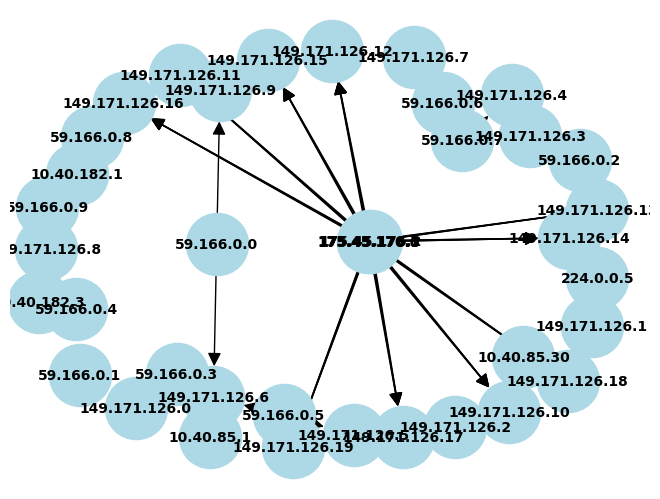

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler


# Load your dataset
df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv')

# Drop specified columns
columns_to_drop = ['dsport', 'sloss', 'dloss', 'Sintpkt', 'Dintpkt', 'Stime', 'Ltime', 'attack_cat']
df = df.drop(columns=columns_to_drop)

# Convert column names to lowercase
df.columns = df.columns.str.lower()

sample_df = df.head(6000)

# Create a directed graph
G = nx.DiGraph()
count = 0
countatt = 0
# Iterate through the sample and add nodes and edges to the graph
for index, row in sample_df.iterrows():
    src_ip = row['srcip']
    dst_ip = row['dstip']
    if src_ip == dst_ip:
        continue
    # Add nodes
    G.add_node(src_ip)
    G.add_node(dst_ip)
    if row['label'] == 1:
        countatt = 1
        edge_attributes = row.drop(['srcip', 'dstip']).to_dict()
        G.add_edge(src_ip, dst_ip, **edge_attributes)
    else:
        if count < 9:
    # Add directed edge with specified attributes
            edge_attributes = row.drop(['srcip', 'dstip']).to_dict()
            G.add_edge(src_ip, dst_ip, **edge_attributes)
            count += 1
    if count >= 10:
        break
        
    

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, font_color='black', node_color='lightblue', font_weight='bold', arrowsize=20)
plt.show()





In [3]:
import os

# Specify the path for the output GEXF file in the Downloads folder
output_file_path = os.path.join(os.path.expanduser('~'), r'C:\Users\jagad\Downloads', 'graph_output.gexf')


# Write the graph to a GEXF file
nx.write_gexf(G, output_file_path)

print(f"Graph has been written to {output_file_path}")


Graph has been written to C:\Users\jagad\Downloads\graph_output.gexf


In [7]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

with GraphDatabase.driver(URI, auth=AUTH) as driver: 
    driver.verify_connectivity()

In [11]:
import csv
from neo4j import GraphDatabase

# Assuming you have a Neo4j server running locally
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"

def create_node(tx, ip_address):
    query = (
        "MERGE (n:IP {ip_address: $ip_address})"
    )
    tx.run(query, ip_address=ip_address)

# Read nodes from CSV file
nodes = []
with open(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Assuming 'srcip' is the column containing IP addresses
        nodes.append({'ip_address': row['srcip']})

# List of edges (replace with your actual data)
edges = [
    {'src_ip': '192.168.1.1', 'dst_ip': '192.168.1.2', 'label': 'some_label', 'proto': 'TCP', 'state': 'ESTABLISHED', 'dur': 10, 'spkts': 100, 'dpkts': 50}
]

# Create a Neo4j session
with GraphDatabase.driver(uri, auth=(username, password)) as driver:
    with driver.session() as session:
        # Create nodes
        for node in nodes:
            session.write_transaction(create_node, node['ip_address'])

        # Create relationships
        with driver.session() as session:
            for edge in edges:
                session.run("""
                    MATCH (src:IP {ip_address: $src_ip}), (dst:IP {ip_address: $dst_ip})
                    MERGE (src)-[:COMMUNICATES_WITH {label: $label, proto: $proto, state: $state, dur: $dur, spkts: $spkts, dpkts: $dpkts}]->(dst)
                """, src_ip=edge['src_ip'], dst_ip=edge['dst_ip'], label=edge['label'], proto=edge['proto'], state=edge['state'], dur=edge['dur'], spkts=edge['spkts'], dpkts=edge['dpkts'])


C:\Users\jagad\AppData\Local\Temp\ipykernel_10064\4227427692.py:33: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_node, node['ip_address'])


In [4]:
from neo4j import GraphDatabase
import csv

# Assuming you have a Neo4j server running locally
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"

def create_relationship(srcip, dstip, label, proto, state, dur, spkts, dpkts):
    def create_relationship_query(tx, srcip, dstip, label, proto, state, dur, spkts, dpkts):
        query = (
            """
            MATCH (src:IP {ip_address: $srcip}), (dst:IP {ip_address: $dstip})
            MERGE (src)-[:COMMUNICATES_WITH {label: $label, proto: $proto, state: $state, dur: $dur, spkts: $spkts, dpkts: $dpkts}]->(dst)
            """
        )
        tx.run(query, srcip=srcip, dstip=dstip, label=label, proto=proto, state=state, dur=dur, spkts=spkts, dpkts=dpkts)

    # Assuming you have a Neo4j driver named 'driver'
    with driver.session() as session:
        session.write_transaction(create_relationship_query, srcip, dstip, label, proto, state, dur, spkts, dpkts)

# Read nodes from CSV file
nodes = []
with open(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Assuming 'srcip' and 'dstip' are the columns containing IP addresses
        nodes.append({
            'src_ip': row['srcip'],
            'dst_ip': row['dstip'],
            'label': row['attack_cat'],  # Assuming 'attack_cat' is the label column
            'proto': row['proto'],
            'state': row['state'],
            'dur': float(row['dur']),
            'Spkts': int(row['Spkts']),
            'Dpkts': int(row['Dpkts'])
        })

# Create a Neo4j session
with GraphDatabase.driver(uri, auth=(username, password)) as driver:
    with driver.session() as session:
        # Create relationships
        for edge in nodes:
            create_relationship(
                edge['src_ip'], edge['dst_ip'],
                edge['label'], edge['proto'], edge['state'],
                edge['dur'], edge['Spkts'], edge['Dpkts']
            )


C:\Users\jagad\AppData\Local\Temp\ipykernel_17876\740628075.py:21: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_relationship_query, srcip, dstip, label, proto, state, dur, spkts, dpkts)


In [1]:
from neo4j import GraphDatabase
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

# Step 1: Query the Graph from Neo4j
def query_neo4j_graph(driver):
    with driver.session() as session:
        # Example: Replace this with your actual Neo4j query
        result = session.run("""
        MATCH (src:IP)-[r:COMMUNICATES_WITH]->(dst:IP)
        RETURN src.ip_address as src_ip, dst.ip_address as dst_ip, r.label as label,
               r.proto as proto, r.state as state, r.dur as dur,
               r.spkts as spkts, r.dpkts as dpkts
        LIMIT 100
        """)

        # Extract data from Neo4j result and create a PyTorch Geometric Data object
        data = Data(
            x=torch.tensor([[], []], dtype=torch.float),  # Replace with your node features
            edge_index=torch.tensor([result['src_ip'], result['dst_ip']], dtype=torch.long),
            y=torch.tensor([1 if label == 'attack' else 0 for label in result['label']], dtype=torch.long)
        )

    return data

# Step 2: Create PyTorch Geometric Data Loader
def create_data_loader(data, batch_size=64, shuffle=True):
    return DataLoader([data], batch_size=batch_size, shuffle=shuffle)

# Step 3: Define and Train the GNN Model
class GNNModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Step 4: Train the Model
def train(model, data_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch in data_loader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch.y)
            loss.backward()
            optimizer.step()
    print("Training completed.")

# Main Code
if __name__ == "__main__":
    # Connect to Neo4j
    neo4j_uri = "bolt://localhost:7687"  # Update with your Neo4j URI
    neo4j_username = "neo4j"
    neo4j_password = "password"

    driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password))

    # Step 1: Query the Graph from Neo4j
    graph_data = query_neo4j_graph(driver)

    # Step 2: Create PyTorch Geometric Data Loader
    data_loader = create_data_loader(graph_data)

    # Step 3: Define and Train the GNN Model
    num_features = graph_data.num_node_features
    num_classes = 2  # Assuming binary classification
    model = GNNModel(num_features, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Step 4: Train the Model
    train(model, data_loader, optimizer, criterion, epochs=10)

    # Close the Neo4j driver
    driver.close()


c:\Users\jagad\anaconda3\envs\tensorflow_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ServiceUnavailable: Couldn't connect to localhost:7687 (resolved to ()):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [WinError 10061] No connection could be made because the target machine actively refused it)
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [WinError 10061] No connection could be made because the target machine actively refused it)

In [10]:
df.columns

NameError: name 'df' is not defined

C:\Users\jagad\AppData\Local\Temp\ipykernel_12204\1241489790.py:6: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv')


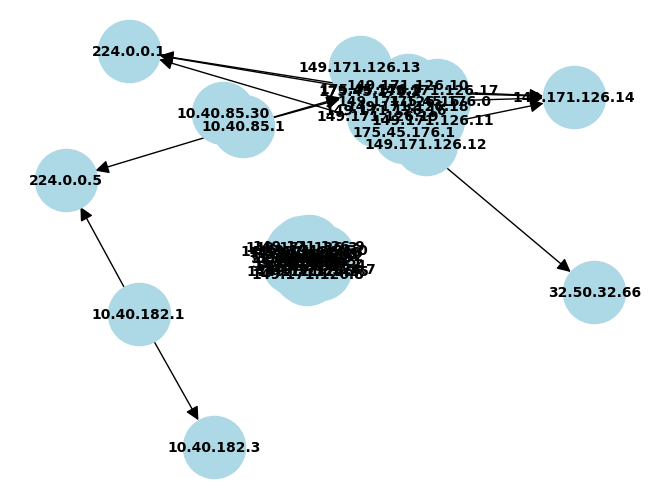

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv')

# Drop specified columns
columns_to_drop = ['dsport', 'sloss', 'dloss', 'Sintpkt', 'Dintpkt', 'Stime', 'Ltime', 'attack_cat']
df = df.drop(columns=columns_to_drop)

# Convert column names to lowercase
df.columns = df.columns.str.lower()

sample_df = df.head(200000)

# Create a directed graph
G = nx.DiGraph()

# Iterate through the sample and add nodes and edges to the graph
for index, row in sample_df.iterrows():
    src_ip = row['srcip']
    dst_ip = row['dstip']
    if src_ip == dst_ip:
        continue
    # Add nodes
    G.add_node(src_ip)
    G.add_node(dst_ip)

    # Add directed edge with specified attributes
    edge_attributes = row.drop(['srcip', 'dstip']).to_dict()
    G.add_edge(src_ip, dst_ip, **edge_attributes)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, font_color='black', node_color='lightblue', font_weight='bold', arrowsize=20)
plt.show()


In [12]:

G.is_directed()


True

In [13]:

I = nx.incidence_matrix(G)

In [14]:

I.todense()

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:

A = nx.adjacency_matrix(G)

In [16]:

A.todense()


array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [17]:

A.diagonal()
     

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [18]:
# Print column names
print(sample_df.columns)


Index(['srcip', 'sport', 'dstip', 'proto', 'state', 'dur', 'sbytes', 'dbytes',
       'sttl', 'dttl', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin',
       'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object')


In [19]:
import torch
from torch_geometric.data import Data

# Assuming G is your NetworkX graph
# G = create_graph(sample_df)  # Your custom function to create a NetworkX graph

# Extract node features and labels
x = torch.tensor([G.nodes[node]['srcip'] for node in G.nodes], dtype=torch.float)
y = torch.tensor([G.nodes[node]['label'] for node in G.nodes], dtype=torch.long)

# Extract edges
edges = list(G.edges())
edge_index = torch.tensor([(src, dst) for src, dst in edges], dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Now 'data' can be used with PyTorch Geometric


KeyError: 'srcip'

In [311]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv')

# Drop specified columns
columns_to_drop = ['dsport', 'sloss', 'dloss', 'Sintpkt', 'Dintpkt', 'Stime', 'Ltime', 'attack_cat']
df = df.drop(columns=columns_to_drop)

# Convert column names to lowercase
df.columns = df.columns.str.lower()

sample_df = df.head(20000)

# Create a directed graph
G = nx.DiGraph()

# Iterate through the sample and add nodes and edges to the graph
for index, row in sample_df.iterrows():
    src_ip = row['srcip']
    dst_ip = row['dstip']
    if src_ip == dst_ip:
        continue
    # Add nodes with features
    G.add_node(src_ip, feature1=row['sbytes'], feature2=row['dbytes'], label=row['label'])
    G.add_node(dst_ip, feature1=row['sbytes'], feature2=row['dbytes'], label=row['label'])

    # Add directed edge with specified attributes
    edge_attributes = row.drop(['srcip', 'dstip', 'sbytes', 'dbytes', 'label']).to_dict()
    G.add_edge(src_ip, dst_ip, **edge_attributes)

# Accessing node features
node_features = {node: G.nodes[node] for node in G.nodes}
print(node_features)


C:\Users\jagad\AppData\Local\Temp\ipykernel_12204\431536742.py:6: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\jagad\Documents\GitHub\Graph-Anomaly-Detection\datasets\combined_data.csv')


{'59.166.0.0': {'feature1': 568, 'feature2': 320, 'label': 0}, '149.171.126.6': {'feature1': 146, 'feature2': 178, 'label': 0}, '149.171.126.9': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '59.166.0.6': {'feature1': 146, 'feature2': 178, 'label': 0}, '149.171.126.7': {'feature1': 2934, 'feature2': 3740, 'label': 0}, '59.166.0.5': {'feature1': 4014, 'feature2': 60268, 'label': 0}, '149.171.126.5': {'feature1': 146, 'feature2': 178, 'label': 0}, '59.166.0.3': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '149.171.126.0': {'feature1': 37484, 'feature2': 3380, 'label': 0}, '149.171.126.4': {'feature1': 146, 'feature2': 178, 'label': 0}, '59.166.0.7': {'feature1': 1920, 'feature2': 4312, 'label': 0}, '59.166.0.1': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '59.166.0.2': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '59.166.0.4': {'feature1': 146, 'feature2': 178, 'label': 0}, '175.45.176.3': {'feature1': 564, 'feature2': 354, 'label': 1}, '149.171.126.18': {'feature

In [312]:
import torch
from torch_geometric.data import Data

# Node features and labels for your graph
node_features = {'59.166.0.0': {'feature1': 568, 'feature2': 320, 'label': 0}, '149.171.126.6': {'feature1': 146, 'feature2': 178, 'label': 0}, '149.171.126.9': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '59.166.0.6': {'feature1': 146, 'feature2': 178, 'label': 0}, '149.171.126.7': {'feature1': 2934, 'feature2': 3740, 'label': 0}, '59.166.0.5': {'feature1': 4014, 'feature2': 60268, 'label': 0}, '149.171.126.5': {'feature1': 146, 'feature2': 178, 'label': 0}, '59.166.0.3': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '149.171.126.0': {'feature1': 37484, 'feature2': 3380, 'label': 0}, '149.171.126.4': {'feature1': 146, 'feature2': 178, 'label': 0}, '59.166.0.7': {'feature1': 1920, 'feature2': 4312, 'label': 0}, '59.166.0.1': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '59.166.0.2': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '59.166.0.4': {'feature1': 146, 'feature2': 178, 'label': 0}, '175.45.176.3': {'feature1': 564, 'feature2': 354, 'label': 1}, '149.171.126.18': {'feature1': 880, 'feature2': 354, 'label': 1}, '175.45.176.2': {'feature1': 794, 'feature2': 6060, 'label': 1}, '149.171.126.16': {'feature1': 168, 'feature2': 0, 'label': 1}, '175.45.176.0': {'feature1': 774, 'feature2': 2198, 'label': 1}, '149.171.126.8': {'feature1': 1684, 'feature2': 10168, 'label': 0}, '59.166.0.8': {'feature1': 146, 'feature2': 178, 'label': 0}, '149.171.126.2': {'feature1': 146, 'feature2': 178, 'label': 0}, '59.166.0.9': {'feature1': 37484, 'feature2': 3380, 'label': 0}, '149.171.126.1': {'feature1': 7818, 'feature2': 14598, 'label': 0}, '149.171.126.10': {'feature1': 702, 'feature2': 3016, 'label': 1}, '149.171.126.3': {'feature1': 4014, 'feature2': 60268, 'label': 0}, '149.171.126.15': {'feature1': 696, 'feature2': 768, 'label': 0}, '149.171.126.14': {'feature1': 794, 'feature2': 6060, 'label': 1}, '149.171.126.12': {'feature1': 564, 'feature2': 354, 'label': 1}, '149.171.126.13': {'feature1': 8867, 'feature2': 1826, 'label': 1}, '175.45.176.1': {'feature1': 982, 'feature2': 714, 'label': 0}, '149.171.126.11': {'feature1': 982, 'feature2': 714, 'label': 0}, '10.40.182.1': {'feature1': 384, 'feature2': 0, 'label': 0}, '224.0.0.5': {'feature1': 384, 'feature2': 0, 'label': 0}, '10.40.85.1': {'feature1': 384, 'feature2': 0, 'label': 0}, '149.171.126.17': {'feature1': 1200, 'feature2': 25120, 'label': 1}, '149.171.126.19': {'feature1': 774, 'feature2': 2198, 'label': 1}, '10.40.85.30': {'feature1': 56, 'feature2': 92, 'label': 0}, '10.40.182.3': {'feature1': 56, 'feature2': 92, 'label': 0}, '224.0.0.1': {'feature1': 86, 'feature2': 0, 'label': 0}}

# Extract node features and labels
x = torch.tensor([[node['feature1'], node['feature2']] for node in node_features.values()], dtype=torch.float)
y = torch.tensor([node['label'] for node in node_features.values()], dtype=torch.long)

# Create edge_index (assuming there are no edges in this example)
edge_index = torch.tensor([], dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Now 'data' can be used with PyTorch Geometric


In [314]:
from torch_geometric.data import Data

# Assuming 'data' is your PyTorch Geometric Data object

# Set a fraction of nodes to be used for training (e.g., 80%)
train_fraction = 0.8

# Get the total number of nodes
num_nodes = data.num_nodes

# Calculate the number of nodes for training
num_train_nodes = int(train_fraction * num_nodes)

# Generate a mask with True for training nodes and False for the rest
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:num_train_nodes] = True

# Set the train_mask attribute in the data object
data.train_mask = train_mask


In [315]:
import torch
import networkx as nx
from torch_geometric.data import Data

# Assuming G is your NetworkX graph

# Create a mapping from node identifiers to integer indices
node_to_index = {node: index for index, node in enumerate(G.nodes)}

# Get the edge_index from the NetworkX graph
edge_index = torch.tensor(
    [(node_to_index[src], node_to_index[dst]) for src, dst in G.edges],
    dtype=torch.long
).t().contiguous()

# You may want to get the node features and labels as well
# For simplicity, let's assume you have node features in a dictionary 'node_features'

# Assuming 'ip_address' is the node identifier
x = torch.tensor([[node_features[node]['feature1'], node_features[node]['feature2']] for node in G.nodes], dtype=torch.float)

# Create a placeholder for node labels (replace this with your actual labels)
y = torch.tensor([0] * len(G.nodes), dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Now 'data' can be used with PyTorch Geometric


In [316]:

print(data)

Data(x=[40, 2], edge_index=[2, 148], y=[40])


In [317]:

data.stores

[{'x': tensor([[5.6800e+02, 3.2000e+02],
         [1.4600e+02, 1.7800e+02],
         [1.6840e+03, 1.0168e+04],
         [1.4600e+02, 1.7800e+02],
         [2.9340e+03, 3.7400e+03],
         [4.0140e+03, 6.0268e+04],
         [1.4600e+02, 1.7800e+02],
         [1.6840e+03, 1.0168e+04],
         [3.7484e+04, 3.3800e+03],
         [1.4600e+02, 1.7800e+02],
         [1.9200e+03, 4.3120e+03],
         [1.6840e+03, 1.0168e+04],
         [1.6840e+03, 1.0168e+04],
         [1.4600e+02, 1.7800e+02],
         [5.6400e+02, 3.5400e+02],
         [8.8000e+02, 3.5400e+02],
         [7.9400e+02, 6.0600e+03],
         [1.6800e+02, 0.0000e+00],
         [7.7400e+02, 2.1980e+03],
         [1.6840e+03, 1.0168e+04],
         [1.4600e+02, 1.7800e+02],
         [1.4600e+02, 1.7800e+02],
         [3.7484e+04, 3.3800e+03],
         [7.8180e+03, 1.4598e+04],
         [7.0200e+02, 3.0160e+03],
         [4.0140e+03, 6.0268e+04],
         [6.9600e+02, 7.6800e+02],
         [7.9400e+02, 6.0600e+03],
         [5.64

In [318]:

data.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [321]:
import torch
from torch_geometric.data import Data

# Assuming 'data' is your PyTorch Geometric Data object

# Set the number of nodes in your graph
num_nodes = data.num_nodes

# Assume you want to use the first 80% of nodes for training
train_percentage = 0.8
num_train_nodes = int(train_percentage * num_nodes)

# Create a boolean mask for training nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:num_train_nodes] = True

# Assign the train_mask to the Data object
data.train_mask = train_mask

# Now you can access data.train_mask
print(data.train_mask)


tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False, False])


In [324]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out,h

# Assuming you have a Data object named 'data'
num_features = data.num_features
num_classes = 2  # Change this based on your number of classes
model = GCN(num_features, num_classes)
print(model)


GCN(
  (conv1): GCNConv(2, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [325]:
model = GCN(num_features, num_classes)

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [40, 2]


In [326]:
model = GCN(num_features, num_classes)
print(model)

GCN(
  (conv1): GCNConv(2, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [327]:
h

tensor([[-0.3616, -0.1217],
        [ 0.8672, -0.7512],
        [ 0.8672, -0.7512],
        [ 0.5006, -0.4620],
        [ 0.8672, -0.7512],
        [ 0.6046, -0.3062],
        [ 0.8672, -0.7512],
        [ 0.6046, -0.3062],
        [ 0.8672, -0.7512],
        [ 0.8672, -0.7512],
        [ 0.6046, -0.3062],
        [ 0.6046, -0.3062],
        [ 0.6046, -0.3062],
        [ 0.3633, -0.2819],
        [-0.0138, -0.0324],
        [ 0.4206, -0.3436],
        [ 0.6046, -0.3062],
        [ 0.4206, -0.3436],
        [ 0.6046, -0.3062],
        [ 0.8672, -0.7512],
        [ 0.5006, -0.4620],
        [ 0.8672, -0.7512],
        [-0.3616, -0.1217],
        [ 0.8672, -0.7512],
        [ 0.4206, -0.3436],
        [ 0.8672, -0.7512],
        [ 0.4206, -0.3436],
        [ 0.4206, -0.3436],
        [ 0.4206, -0.3436],
        [ 0.4206, -0.3436],
        [-0.3616, -0.1217],
        [ 0.4206, -0.3436],
        [-0.3616, -0.1217],
        [-0.4619, -0.1933],
        [-0.3616, -0.1217],
        [ 0.4206, -0

In [328]:

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(12,8))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [329]:
from sklearn.manifold import TSNE

def visualize_tsne(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
     

In [330]:
data.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

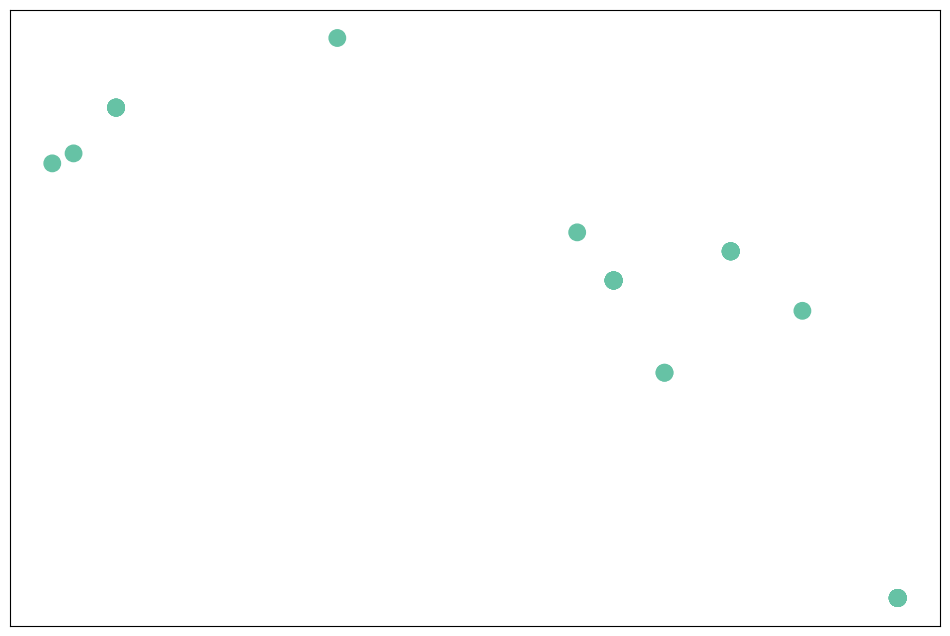

In [332]:
visualize_embedding(h, color=data.y)

In [331]:
model = GCN(num_features, num_classes)
print(model)

GCN(
  (conv1): GCNConv(2, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [333]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

     

<IPython.core.display.Javascript object>

In [334]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

In [335]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.


In [336]:
final_h = h

In [337]:

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

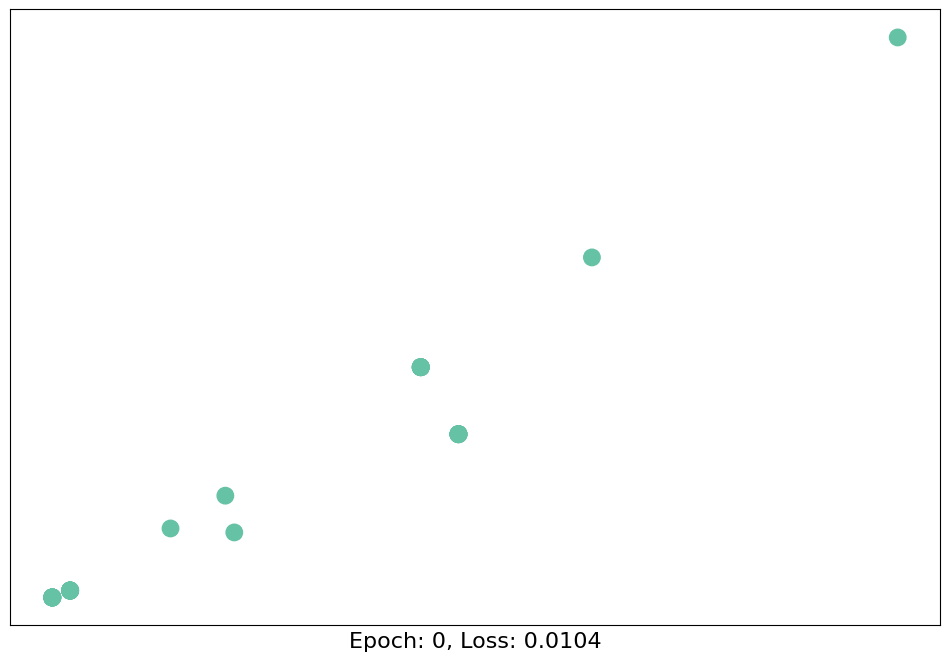

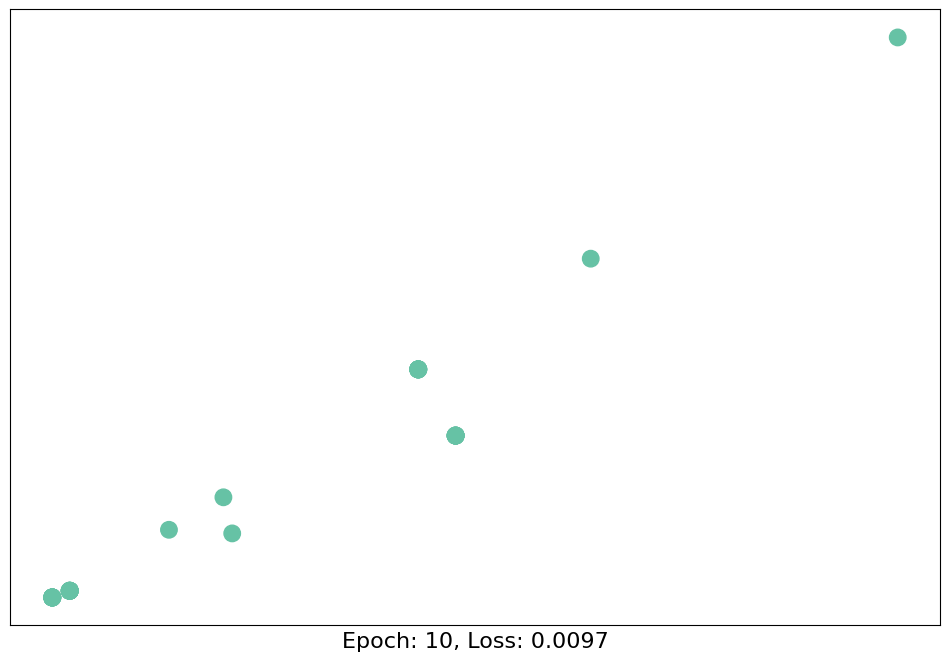

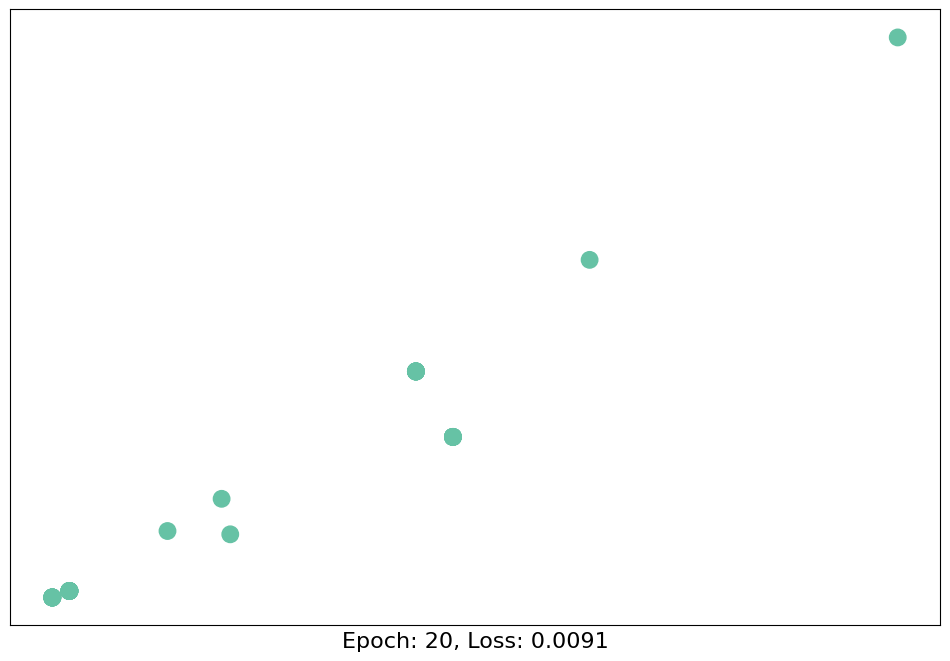

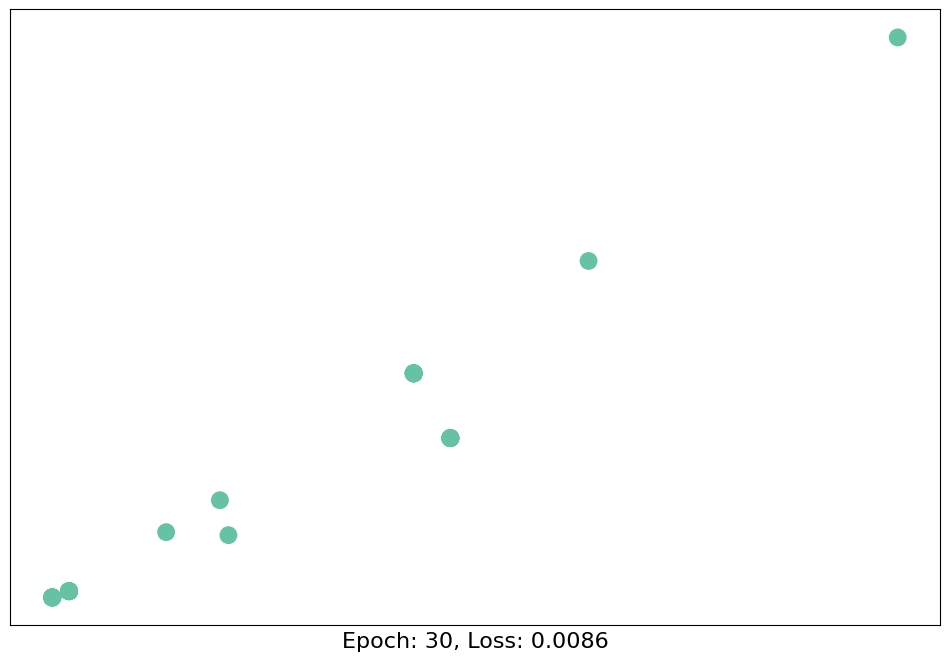

In [339]:
for epoch in range(40):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)
        ## Added by Me
        final_h = h

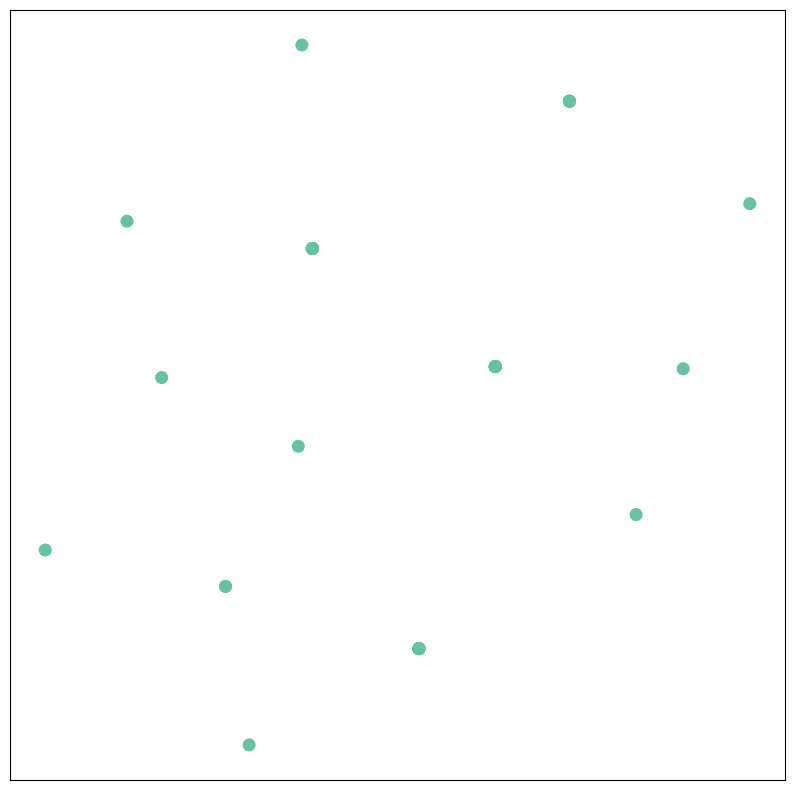

In [340]:

visualize_tsne(h, color=data.y)

In [341]:

model.eval()
out = model(data.x, data.edge_index)
out

(tensor([[ 2.2810, -2.4885],
         [ 2.3319, -2.5365],
         [ 2.3319, -2.5365],
         [ 2.2810, -2.4885],
         [ 2.3319, -2.5365],
         [ 2.2859, -2.4900],
         [ 2.3319, -2.5365],
         [ 2.2859, -2.4900],
         [ 2.3319, -2.5365],
         [ 2.3319, -2.5365],
         [ 2.2859, -2.4900],
         [ 2.2859, -2.4900],
         [ 2.2859, -2.4900],
         [ 2.2078, -2.4209],
         [ 2.2556, -2.4647],
         [ 2.3300, -2.5346],
         [ 2.2859, -2.4900],
         [ 2.3300, -2.5346],
         [ 2.2859, -2.4900],
         [ 2.3319, -2.5365],
         [ 2.2810, -2.4885],
         [ 2.3319, -2.5365],
         [ 2.2810, -2.4885],
         [ 2.3319, -2.5365],
         [ 2.3300, -2.5346],
         [ 2.3319, -2.5365],
         [ 2.3300, -2.5346],
         [ 2.3300, -2.5346],
         [ 2.3300, -2.5346],
         [ 2.3300, -2.5346],
         [ 2.2810, -2.4885],
         [ 2.3300, -2.5346],
         [ 2.2810, -2.4885],
         [ 2.3166, -2.5219],
         [ 2.2

In [342]:

model.state_dict()

OrderedDict([('conv1.bias', tensor([ 0.0913,  0.0000,  0.0000, -0.0609])),
             ('conv1.lin.weight',
              tensor([[ 0.4405, -0.2441],
                      [ 0.5674,  0.1261],
                      [ 0.5497,  0.6416],
                      [-0.5022,  0.3026]])),
             ('conv2.bias', tensor([ 0.3005,  0.2662, -0.1070,  0.3938])),
             ('conv2.lin.weight',
              tensor([[ 0.2738, -0.0084,  0.3434,  0.5499],
                      [ 0.3228,  0.1364,  1.0537, -0.4396],
                      [-0.1122, -0.9699, -0.0346,  0.1579],
                      [-0.6171,  0.7481,  0.2480, -0.4865]])),
             ('conv3.bias', tensor([-0.3388, -0.4203])),
             ('conv3.lin.weight',
              tensor([[-0.7571, -0.9094,  0.1329, -0.5784],
                      [-0.5878,  0.0602,  0.7334, -1.2134]])),
             ('classifier.weight',
              tensor([[-0.8479, -1.1564],
                      [ 1.0658,  0.7336]])),
             ('classifier.bias',

In [344]:

model.get_submodule

<bound method Module.get_submodule of GCN(
  (conv1): GCNConv(2, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)>

In [343]:
model.get_parameter

<bound method Module.get_parameter of GCN(
  (conv1): GCNConv(2, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)>

In [345]:
from sklearn.metrics import f1_score, accuracy_score

# Assuming you have a tensor of test node indices
test_indices = ...  # Replace this with your actual test node indices

# Create a test mask based on the test indices
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[test_indices] = True

# Extract labels for train and test sets
y_train = data.y[data.train_mask]
y_test = data.y[test_mask]

# Get the model’s predictions on the test set
model.eval()
with torch.no_grad():
    out, h = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    y_pred = pred[test_mask]

# Calculate the F1 score and accuracy
f1 = f1_score(y_test.cpu(), y_pred.cpu(), average='macro')
acc = accuracy_score(y_test.cpu(), y_pred.cpu())

print(f'F1 score: {f1:.4f}')
print(f'Accuracy: {acc:.4f}')


F1 score: 1.0000
Accuracy: 1.0000
